# Translating with Attention

This notebook provides a complete code example that demonstrates how to implement a sequence-to-sequence (seq2seq) model for machine translation using recurrent neural networks and the attention mechanism.

## Building the Vocabularies

Implement a function to tokenize and standardize text ...

In [1]:
import contractions
from transformers import BasicTokenizer

tokenizer= BasicTokenizer(do_lower_case=False)

def tokenize(text, lang):
    """Standardize, tokenize, and filter text using Hugging Face tokenizers."""
    text = text.replace("’", "'").replace("‘", "'")
    text = contractions.fix(text) if lang == "eng" else text
    tokens = tokenizer.tokenize(text)
    return tokens

... a function to read and tokenize sentences by iterating through a corpus file ...

In [2]:
import unicodedata

def corpus_iterator(filename, lang, lang_position):
    """Read and tokenize texts by iterating through a corpus file."""
    with open(filename, "r", encoding="utf-8") as file:
        for line in file:
            sentences = line.strip().split("\t")
            sentence = unicodedata.normalize("NFC", sentences[lang_position])
            yield tokenize(sentence, lang)

... a function to build a vocabulary from a corpus file ...

In [3]:
class Vocab:
    """Wrapper around a dictionary to make it callable like torchtext's Vocab."""
    def __init__(self, vocab_dict, unk_token="<unk>"):
        self.vocab_dict = vocab_dict
        self.unk_token = unk_token
        self.default_index = vocab_dict.get(unk_token, -1)
        self.index_to_token = {idx: token for token, idx in vocab_dict.items()}
        
    def __call__(self, token_or_tokens):
        """Make the vocab callable to return the index for a given token or list of tokens."""
        if isinstance(token_or_tokens, list):
            return [self.vocab_dict.get(token, self.default_index) for token in token_or_tokens]
        return self.vocab_dict.get(token_or_tokens, self.default_index)
    
    def set_default_index(self, index):
        """Set default index for unknown tokens."""
        self.default_index = index

    def lookup_token(self, index_or_indices):
        """Retrieve the token corresponding to a given index or list of indices."""
        if isinstance(index_or_indices, list):
            return [self.index_to_token.get(int(index), self.unk_token) for index in index_or_indices]
        return self.index_to_token.get(int(index_or_indices), self.unk_token)

    def get_itos(self):
        """Return a list of tokens ordered by their index."""
        itos = [None] * len(self.index_to_token)
        for index, token in self.index_to_token.items():
            itos[index] = token
        return itos
        
    def __iter__(self):
        """Iterate over the tokens in the vocabulary."""
        return iter(self.vocab_dict)

    def __len__(self):
        """Return the number of tokens in the vocabulary."""
        return len(self.vocab_dict)
    
    def __contains__(self, token):
        """Check if a token is in the vocabulary."""
        return token in self.vocab_dict


In [4]:
from collections import Counter

def build_vocab_from_iterator(iterator, specials=None, min_freq=1):
    """Build vocabulary from an iterator over tokenized sentences."""
    # Count the frequency of each token
    counter = Counter(token for tokens in iterator for token in tokens)

    # Initialize the vocabulary with special tokens
    vocab = {}
    index = 0

    if specials:
        for token in specials:
            vocab[token] = index
            index += 1

    # Add tokens that meet the minimum frequency
    for token, freq in counter.items():
        if freq >= min_freq:
            vocab[token] = index
            index += 1

    return vocab

In [5]:
def build_vocab(filename, lang, lang_position, specials=None, min_freq=5):
    if specials is None:
        specials = ["<unk>"]
    
    vocab_dict = build_vocab_from_iterator(
        corpus_iterator(filename, lang, lang_position),
        min_freq=min_freq,
        specials=specials,
    )
    vocab = Vocab(vocab_dict, unk_token="<unk>")
    vocab.set_default_index(vocab(vocab.unk_token))
    return vocab

... and build the vocabularies.

In [6]:
in_lang, out_lang, filename = "eng", "spa", "eng-spa.txt"
specials = ["<pad>", "<sos>", "<eos>", "<unk>"]

in_vocab = build_vocab(filename, in_lang, lang_position=0, specials=specials)
out_vocab = build_vocab(filename, out_lang, lang_position=1, specials=specials)

## Preprocessing the Data

Implement a function to check if all words in a sentence are present in a vocabulary ...

In [7]:
def all_words_in_vocab(sentence, vocab):
    """Check whether all words in a sentence are present in a vocabulary"""
    return all(word in vocab for word in sentence)

... a function to pad a sequence of tokens ...

In [8]:
def pad(tokens, max_length=10):
    """Pad sequence of tokens."""
    padding_length = max_length - len(tokens)
    return ["<sos>"] + tokens + ["<eos>"] + ["<pad>"] * padding_length

... a function to process the language corpus ...

In [9]:
import numpy as np

def process(filename, in_lang, out_lang, in_vocab, out_vocab, max_length=10):
    """Process language corpus."""
    in_sequences, out_sequences = [], []
    with open(filename, "r", encoding="utf-8") as file:
        for line in file:
            texts = line.strip().split("\t")
            in_tokens = tokenize(unicodedata.normalize("NFC", texts[0]), in_lang)
            out_tokens = tokenize(unicodedata.normalize("NFC", texts[1]), out_lang)

            if (all_words_in_vocab(in_tokens, in_vocab)
                and len(in_tokens) <= max_length
                and all_words_in_vocab(out_tokens, out_vocab)
                and len(out_tokens) <= max_length):
                
                padded_in_tokens = pad(in_tokens)
                in_sequence = in_vocab(padded_in_tokens)
                in_sequences.append(in_sequence)

                padded_out_tokens = pad(out_tokens)
                out_sequence = out_vocab(padded_out_tokens)
                out_sequences.append(out_sequence)
    return np.array(in_sequences), np.array(out_sequences)

... and build the datasets and data loaders.

In [10]:
import deeptrack as dt
import torch
from torch.utils.data import DataLoader

in_sequences, out_sequences = \
    process(filename, in_lang, out_lang, in_vocab, out_vocab)

sources = dt.sources.Source(inputs=in_sequences, targets=out_sequences)
train_sources, test_sources = dt.sources.random_split(sources, [0.85, 0.15])

inputs_pip = dt.Value(sources.inputs) >> dt.pytorch.ToTensor(dtype=torch.int)
outputs_pip = dt.Value(sources.targets) >> dt.pytorch.ToTensor(dtype=torch.int)

train_dataset = \
    dt.pytorch.Dataset(inputs_pip & outputs_pip, inputs=train_sources)
test_dataset = \
    dt.pytorch.Dataset(inputs_pip & outputs_pip, inputs=test_sources)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

## Defining the Attention Mechanism

Prepare a class implementing dot-product attention ...

In [11]:
import torch.nn.functional as F
import deeplay as dl

class DotProductAttention(dl.DeeplayModule):
    def __init__(self):
        super().__init__()

    def forward(self, queries, keys, values):
        attn_scores = torch.matmul(queries, keys.transpose(-2, -1)) / (keys.size(-1) ** 0.5) # Calculate dot-product
        attn_weights = F.softmax(attn_scores, dim=-1)  # Apply softmax to get attention weights
        attn_output = torch.matmul(attn_weights, values)  # Compute weighted sum of values
        return attn_output, attn_weights


## Implementing and Training the Sequence-to-Sequence Architecture

Implement the encoder ...

In [12]:
import deeplay as dl

class Seq2SeqEncoder(dl.DeeplayModule):
    """Sequence-to-sequence encoder."""

    def __init__(self, vocab_size, in_features=300, hidden_features=128,
                 hidden_layers=1, dropout=0.0):
        """Initialize sequence-to-sequence encoder."""
        super().__init__()

        self.hidden_features = hidden_features
        self.hidden_layers = hidden_layers
        
        self.embedding = dl.Layer(torch.nn.Embedding, vocab_size, in_features)
        self.rnn = dl.Layer(torch.nn.GRU, input_size=in_features, \
            hidden_size=hidden_features, num_layers=hidden_layers, \
            dropout=(0 if hidden_layers == 1 else dropout), \
            bidirectional=True, batch_first=True)

    def forward(self, in_sequences, contexts=None):
        """Perform forward pass."""
        in_embeddings = self.embedding(in_sequences)
        encoded_sequences, contexts = self.rnn(in_embeddings, contexts)
        encoded_sequences = (encoded_sequences[:, :, :self.hidden_features]
                          + encoded_sequences[:, :, self.hidden_features:])
        contexts = contexts[:self.hidden_layers] # only forward
        return encoded_sequences, contexts

... implement the decoder ...

In [13]:
class Seq2SeqDecoder(dl.DeeplayModule):
    """Sequence-to-sequence decoder with attention."""

    def __init__(self, vocab_size, in_features=300, hidden_features=128, 
                 hidden_layers=1, dropout=0.0):
        """Initialize sequence-to-sequence decoder."""
        super().__init__()

        self.embedding = dl.Layer(torch.nn.Embedding, vocab_size, in_features)
        self.rnn = dl.Layer(torch.nn.GRU, \
            input_size=in_features, hidden_size=hidden_features, \
            num_layers=hidden_layers, bidirectional=False, batch_first=True, \
            dropout=(0 if hidden_layers == 1 else dropout))
        self.dense = dl.Layer(torch.nn.Linear, hidden_features, vocab_size)
        self.softmax = dl.Layer(torch.nn.Softmax, dim=-1)
        self.attn = DotProductAttention()

    def forward(self, decoder_in_values, contexts, encoded_sequences):
        """Perform forward pass."""        
        out_embeddings = self.embedding(decoder_in_values)  
        decoder_outputs, contexts = self.rnn(out_embeddings, contexts)
        attn_contexts, attn_weights = self.attn(queries = decoder_outputs, \
            keys = encoded_sequences, values = encoded_sequences)

        decoder_outputs = decoder_outputs + attn_contexts
        decoder_outputs = self.dense(decoder_outputs)
        decoder_outputs = self.softmax(decoder_outputs)

        return decoder_outputs, contexts, attn_weights

... implement the full seq2seq model combining the encoder and decoder ...

In [14]:
class Seq2SeqModel(dl.DeeplayModule):
    """Sequence-to-sequence model with attention."""

    def __init__(self, in_vocab_size=None, out_vocab_size=None,
                 teacher_prob=1.0, embedding_dim=300, hidden_features=128,
                 hidden_layers=1, dropout=0.0):
        """Initialize the sequence-to-sequence model."""
        super().__init__()
        
        self.in_vocab_size, self.out_vocab_size = in_vocab_size, out_vocab_size
        self.encoder = Seq2SeqEncoder(in_vocab_size, embedding_dim, \
            hidden_features, hidden_layers, dropout)
        self.decoder = Seq2SeqDecoder(out_vocab_size, embedding_dim, \
            hidden_features, hidden_layers, dropout)
        self.teacher_prob = teacher_prob


    def forward(self, batch):
        """Perform forward pass."""
        in_sequences, out_sequences = batch
        num_sequences, sequence_length = in_sequences.size()
        device = next(self.encoder.parameters()).device
        
        encoder_outputs, contexts = self.encoder(in_sequences)
        
        decoder_outputs_vec = torch.zeros(num_sequences, sequence_length,
                                          self.out_vocab_size).to(device)
        decoder_in_values = torch.full(size=(num_sequences, 1), 
                                          fill_value=1, device=device)  # <sos>
        for t in range(sequence_length):
            decoder_outputs, contexts, _ = \
                self.decoder(decoder_in_values, contexts, encoder_outputs)
            decoder_outputs_vec[:, t, :] = decoder_outputs.squeeze(1)
            
            if (np.random.rand() < self.teacher_prob 
                and t < sequence_length - 1):  # Teacher forcing.
                decoder_in_values = \
                    out_sequences[:, t + 1].unsqueeze(-1).to(device)
            else:  # Model prediction.
                _, top_decoder_outputs = decoder_outputs.topk(1)
                decoder_in_values = \
                    top_decoder_outputs.squeeze(-1).detach().to(device)  
                  
        return decoder_outputs_vec

    def evaluate(self, in_sequences):
        """Evaluate model."""
        num_sequences, sequence_length = in_sequences.size()
        device = next(self.encoder.parameters()).device

        with torch.no_grad():
            encoder_outputs, contexts = self.encoder(in_sequences)
        
        pred_sequences = torch.zeros(num_sequences, sequence_length).to(device)
        decoder_in_values = torch.full(size=(num_sequences, 1), 
                                       fill_value=1, device=device)  # <sos>
        attn_matrices = torch.zeros(num_sequences, sequence_length, sequence_length).to(device)                             
        for t in range(sequence_length):
            with torch.no_grad():
                decoder_outputs, contexts, attn_weights = \
                    self.decoder(decoder_in_values, contexts, encoder_outputs)
            attn_matrices[:, t, :] = attn_weights.squeeze(1)
            _, top_decoder_outputs = decoder_outputs.topk(1)
            pred_sequences[:, t] = top_decoder_outputs.squeeze()
            
            decoder_in_values = top_decoder_outputs.squeeze(-1).detach()
            
            
        return pred_sequences, attn_matrices

... define the loss function ...

In [15]:
def maskedNLL(decoder_outputs, out_sequences, padding=0):
    """Calculate the masked negative log-likelihood (NLL) loss."""
    flat_pred_sequences = decoder_outputs.view(-1, decoder_outputs.shape[-1])
    flat_target_sequences = out_sequences.view(-1, 1)
    pred_probs = torch.gather(flat_pred_sequences, 1, flat_target_sequences)

    nll = - torch.log(pred_probs)

    mask = out_sequences != padding
    masked_nll = nll.masked_select(mask.view(-1, 1))
    
    return masked_nll.mean()  # Loss.

... implement the sequence-to-sequence application ...

In [16]:
class Seq2Seq(dl.Application):
    """Application for the sequence-to-sequence model."""

    def __init__(self, in_vocab, out_vocab, teacher_prob=1.0, attn=None):
        """Initialize the application."""
        super().__init__(loss=maskedNLL, optimizer=dl.Adam(lr=1e-3))
        self.model = Seq2SeqModel(in_vocab_size=len(in_vocab), \
            out_vocab_size=len(out_vocab), teacher_prob=teacher_prob)

    def train_preprocess(self, batch):
        """Adjust the target sequence by shifting it one position backward."""
        in_sequences, out_sequences = batch
        shifted_out_sequences = \
            torch.cat((out_sequences[:, 1:], out_sequences[:, -1:]), dim=1)
        return (in_sequences, out_sequences), shifted_out_sequences
    
    def forward(self, batch):
        """Perform forward pass."""
        return self.model(batch)

... load some pretrained embeddings ...

In [ ]:
def load_glove_embeddings(file_path, embedding_dim):
    """Load GloVe embeddings from a file."""
    embeddings = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            if len(vector) == embedding_dim:  # Ensure correct dimensionality
                embeddings[word] = vector
    return embeddings

def get_glove_embeddings(vocab, glove_embeddings, embedding_dim):
    """Get embeddings for a vocabulary using GloVe."""
    embeddings_matrix = np.zeros((len(vocab), embedding_dim))
    for idx, token in enumerate(vocab):
        # Get the GloVe embedding or a zero vector if token not found
        embeddings_matrix[idx] = glove_embeddings.get(token, np.zeros(embedding_dim))
    return torch.tensor(embeddings_matrix, dtype=torch.float32)

# Define the GloVe file path and embedding dimensions
glove_file_path = 'glove/glove.6B/glove.6B.300d.txt'  # Replace with the actual file path
embedding_dim = 300

# Load the GloVe embeddings
glove_embeddings = load_glove_embeddings(glove_file_path, embedding_dim)

# Get the embeddings for the vocabularies
glove_embeddings_in = get_glove_embeddings(in_vocab.get_itos(), glove_embeddings, embedding_dim)
glove_embeddings_out = get_glove_embeddings(out_vocab.get_itos(), glove_embeddings, embedding_dim)

num_specials = len(specials)
glove_embeddings_in[1:num_specials] = \
    torch.rand(num_specials - 1, embedding_dim) * 0.01
glove_embeddings_out[1:num_specials] = \
    torch.rand(num_specials - 1, embedding_dim) * 0.01

... instantiate the seq2seq model ...

In [18]:
seq2seq = Seq2Seq(in_vocab=in_vocab, out_vocab=out_vocab, teacher_prob=0.85)
seq2seq = seq2seq.create()

seq2seq.model.encoder.embedding.weight.data = glove_embeddings_in
seq2seq.model.encoder.embedding.weight.requires_grad = False
seq2seq.model.decoder.embedding.weight.data = glove_embeddings_out
seq2seq.model.decoder.embedding.weight.requires_grad = False

... you might want to check the number of learnable parameters ...

In [19]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(seq2seq)

1693125

... and train the model ...

In [20]:
trainer = dl.Trainer(max_epochs=25, accelerator="auto")
trainer.fit(seq2seq, train_loader)

/Users/841602/Documents/GitHub/Environments/deeplay_env/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
2024-10-07 16:38:10.642162: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ train_metrics │ MetricCollection │      0 │ train │
│ 1 │ val_metrics   │ MetricCollection │      0 │ train │
│ 2 │ test_metrics  │ MetricCollection │      0 │ train │
│ 3 │ model         │ Seq2SeqModel     │  6.3 M │ train │
│ 4 │ optimizer     │ Adam             │      0 │ train │
└───┴───────────────┴──────────────────┴────────┴───────┘

Trainable params: 1.7 M                                                                                            
Non-trainable params: 4.6 M                                                                                        
Total params: 6.3 M                                                                                                
Total estimated model params size (MB): 25                                                                         
Modules in train mode: 14                                                                                          
Modules in eval mode: 0

Output()

/Users/841602/Documents/GitHub/Environments/deeplay_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


## Testing the Model Perfomance

Implement a function to convert numerical sequences into their corresponding text ...

In [21]:
def unprocess(sequences, vocab, specials):
    """Convert numeric sequences to sentences."""
    sentences = []
    for sequence in sequences:
        idxs = sequence[sequence > len(specials) - 1]
        words = [vocab.lookup_token(idx) for idx in idxs]
        sentences.append(" ".join(words))
    return sentences

... a function to translate user-defined sentences ...

In [22]:
def translate(in_sentence, model, in_lang, in_vocab, out_vocab, specials):
    """Translate a sentence."""
    in_sentence = unicodedata.normalize("NFC", in_sentence)
    in_tokens = pad(tokenize(in_sentence, in_lang))
    in_sequence = (torch.tensor(in_vocab(in_tokens), dtype=torch.int)
                   .unsqueeze(0).to(next(model.parameters()).device))
    pred_sequence, attn_matrix = model.evaluate(in_sequence)
    pred_sentence = unprocess(pred_sequence, out_vocab, specials)
    pred_tokens = [out_vocab.lookup_token(idx) for idx in pred_sequence[0]]

    print(f"Predicted Translation: {pred_sentence[0]}\n")

    return (in_tokens, pred_tokens, attn_matrix.squeeze())

... and a function for plotting the attention matrix as a heatmap ...

In [23]:
from matplotlib import pyplot as plt 
from matplotlib.ticker import FixedLocator

def plot_attention(in_tokens, out_tokens, attn_matrix, specials = None):

    if specials is None:
        specials = ["<pad>", "<sos>", "<eos>", "<unk>"]

    if specials[1] in in_tokens:
        in_tokens = in_tokens[1:]
        out_tokens = out_tokens[:-1]
        attn_matrix = attn_matrix[:-1, 1:] 

    eos_in_index = in_tokens.index(specials[2]) if specials[2] in in_tokens else len(in_tokens)
    eos_out_index = out_tokens.index(specials[2]) if specials[2] in out_tokens else len(out_tokens)

    cut_index = max(eos_in_index, eos_out_index)
    filtered_in_tokens = in_tokens[:cut_index]
    filtered_out_tokens = out_tokens[:cut_index]
    filtered_attn_matrix = attn_matrix[:cut_index, :cut_index]

    fig, ax = plt.subplots()
    cax = ax.matshow(filtered_attn_matrix, cmap="bone")
    fig.colorbar(cax)

    ax.xaxis.set_major_locator(FixedLocator(range(len(filtered_in_tokens))))
    ax.yaxis.set_major_locator(FixedLocator(range(len(filtered_out_tokens))))
    ax.set_xticklabels(filtered_in_tokens, rotation=90)
    ax.set_yticklabels(filtered_out_tokens)

    ###  plt.savefig("fig_08_Xn.pdf")  
    plt.show()


... try to translate a simple sentence ...

Predicted Translation: Este libro es muy interesante .



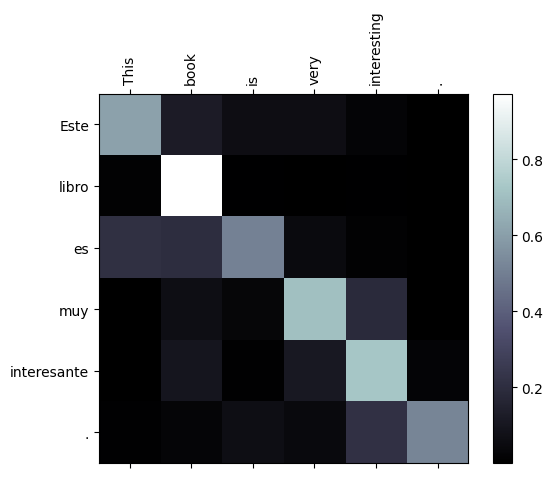

In [24]:
in_sentence = "This book is very interesting."
out = translate(in_sentence, seq2seq.model, in_lang, in_vocab, out_vocab, specials)
plot_attention(*out)

... and more complex ones ...

Predicted Translation: El libro que compré es muy interesante .



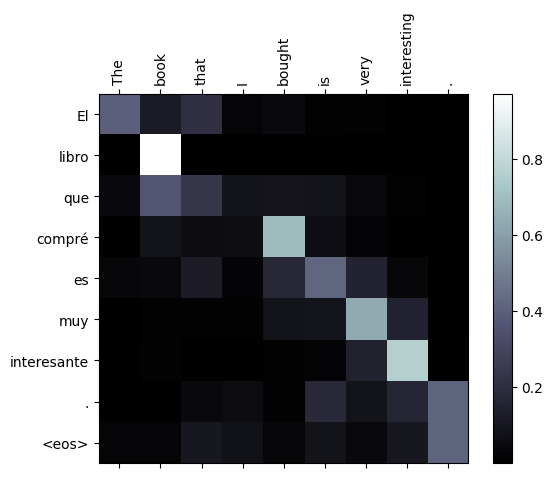

In [25]:
in_sentence = "The book that I bought is very interesting."
out = translate(in_sentence, seq2seq.model, in_lang, in_vocab, out_vocab, specials)
plot_attention(*out)

Predicted Translation: ¿ Crees que deberíamos ir a casa ?



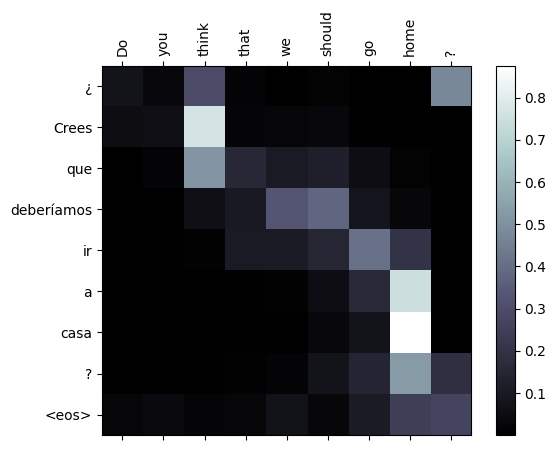

In [26]:
in_sentence = "Do you think that we should go home?"
out = translate(in_sentence, seq2seq.model, in_lang, in_vocab, out_vocab, specials)
plot_attention(*out)

Predicted Translation: ¡ Debería irme a casa !



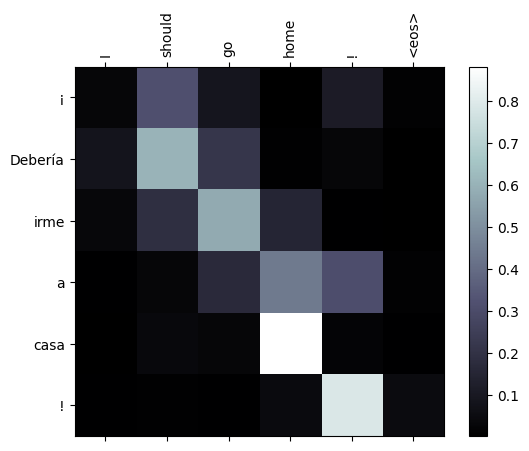

In [27]:
in_sentence = "I should go home!"
out = translate(in_sentence, seq2seq.model, in_lang, in_vocab, out_vocab, specials)
plot_attention(*out)

Predicted Translation: El hombre compró la libro que yo .



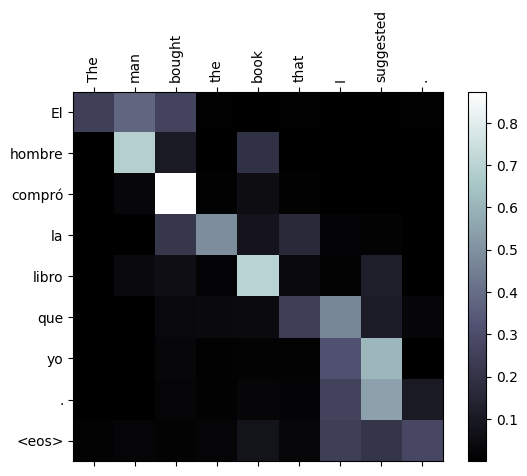

In [28]:
in_sentence = "The man bought the book that I suggested."
out = translate(in_sentence, seq2seq.model, in_lang, in_vocab, out_vocab, specials)
plot_attention(*out)

Predicted Translation: El policía llamó al jefe al teléfono . .



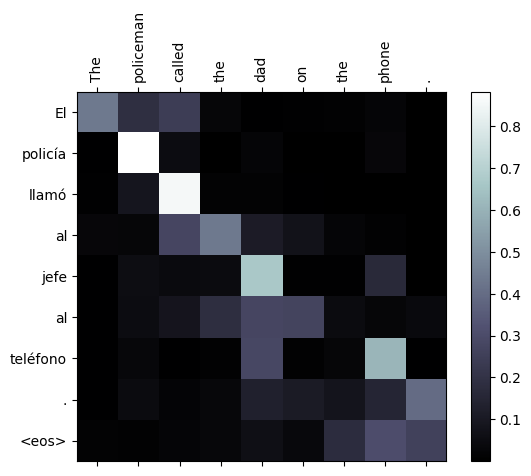

In [29]:
in_sentence = "The policeman called the dad on the phone."
out = translate(in_sentence, seq2seq.model, in_lang, in_vocab, out_vocab, specials)
plot_attention(*out)

## Evaluating the Model with the BLEU Score

In [30]:
from torchmetrics.text import BLEUScore

bleu_score = BLEUScore()

device = next(seq2seq.model.parameters()).device
for batch_index, (in_sequences, out_sequences) in enumerate(test_loader):
    in_sentences = unprocess(in_sequences.to(device), in_vocab, specials)
    pred_sequences,_ = seq2seq.model.evaluate(in_sequences.to(device))
    pred_sentences = unprocess(pred_sequences, out_vocab, specials)
    out_sentences = unprocess(out_sequences.to(device), out_vocab, specials)
    
    bleu_score.update(pred_sentences, [[s] for s in out_sentences])

    print(f"Input text: {in_sentences[0]}\n" 
          + f"Predicted Translation: {pred_sentences[0]}\n"
          + f"Actual Translation: {out_sentences[0]}\n")

final_bleu = bleu_score.compute()
print(f"Validation BLEU Score: {final_bleu:.3f}")

Input text: I want to go back to my room .
Predicted Translation: Quiero volver a mi cuarto .
Actual Translation: Quiero volver a mi cuarto .

Input text: Our school did away with uniforms last year .
Predicted Translation: Nuestra escuela se hacía con el año pasado .
Actual Translation: Nuestro colegio abandonó los uniformes el año pasado .

Input text: This is not silver .
Predicted Translation: Esto no es plata .
Actual Translation: Esto no es plata .

Input text: Are we just friends ?
Predicted Translation: ¿ Somos somos amigos ?
Actual Translation: ¿ Acaso somos solo amigos ?

Input text: I get you .
Predicted Translation: Te pillo .
Actual Translation: Te entiendo .

Input text: Tom saw that Mary was busy .
Predicted Translation: Tom vio que Mary estaba ocupada .
Actual Translation: Tom miró que Mary estaba ocupada .

Input text: Tom is due to arrive here soon .
Predicted Translation: Tom se está a llegar a llegar pronto .
Actual Translation: Tom debería llegar aquí pronto .

Inp

## Experiment with Other Attention Mechanisms

Prepare a class implementing standard scaled dot-product attention ...

In [31]:
import torch.nn as nn


class StandardAttention(dl.DeeplayModule):

    def __init__(self, num_in_features=128, num_out_features=256):
        super().__init__()
        self.Wq = nn.Linear(num_in_features, num_out_features)
        self.Wk = nn.Linear(num_in_features, num_out_features)
        self.Wv = nn.Linear(num_in_features, num_out_features)

    def forward(self, queries, keys, values):
        Q = self.Wq(queries)
        K = self.Wk(keys) 
        V = self.Wv(values)  
        
        attn_scores = torch.matmul(Q, K.transpose(-2, -1))  \
            / (K.size(-1) ** 0.5)
        attn_weights = F.softmax(attn_scores, dim=-1)
        attn_output = torch.matmul(attn_weights, V)
        return attn_output, attn_weights

... general attention (Luong) ...

In [32]:
class GeneralAttention(dl.DeeplayModule):


    def __init__(self, num_in_features=128, num_out_features=128):
        super().__init__()
        self.Wk = nn.Linear(num_in_features, num_out_features)

    def forward(self, queries, keys, values):
        Q = queries
        K = self.Wk(keys) 
        V = values
        
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) \
            / (K.size(-1) ** 0.5)
        attn_weights = F.softmax(attn_scores, dim=-1)
        attn_output = torch.matmul(attn_weights, V)
        return attn_output, attn_weights

... and additive attention (Bahdanau).

In [33]:
class AdditiveAttention(dl.DeeplayModule):


    def __init__(self, num_in_features=128, num_out_features=256):
        super().__init__()
        self.Wq = nn.Linear(num_in_features, num_out_features)
        self.Wk = nn.Linear(num_in_features, num_out_features)
        self.Ws = nn.Linear(num_out_features, 1)

    def forward(self, queries, keys, values):
        Q = self.Wq(queries)
        K = self.Wk(keys) 
        V = values

        attn_scores = torch.tanh(Q + K)
        attn_scores = self.Ws(attn_scores)

        attn_scores = attn_scores.transpose(-2, -1)
        attn_weights = F.softmax(attn_scores, dim=-1)

        attn_output = torch.matmul(attn_weights, V)
        return attn_output, attn_weights

Substitute the attention in the model, change parameters accordingly and train...

In [34]:
seq2seq.model.decoder.replace('attn',AdditiveAttention())

seq2seq.model.decoder.attn.configure(num_out_features = 128)


AdditiveAttention(
  (Wq): Linear(in_features=128, out_features=128, bias=True)
  (Wk): Linear(in_features=128, out_features=128, bias=True)
  (Ws): Linear(in_features=128, out_features=1, bias=True)
)